<a href="https://colab.research.google.com/github/simulate111/Computer-Vision-and-Sensor-Fusion/blob/main/Assignment_1_template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import random
import os
import numpy as np
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models

### Path system

In [ ]:
# you need the current working directory NB: works both windows and linux
current_working_directory = os.getcwd()
current_working_directory = os.path.dirname(current_working_directory)

# get the directory where I want to download the dataset
path_of_download = os.path.join(*['..', current_working_directory, 'Datasets', 'cookies_vs_chihuahua'])
print(f"[DIR] The directory of the current dataset is {path_of_download}")

[DIR] The directory of the current dataset is C:\Users\moakht\OneDrive - O365 Turun yliopisto\Desktop\Courses\UTU\Computer Vision and Sensor Fusion\Datasets\cookies_vs_chihuahua


### Dataset function

In [ ]:
# here let s do some functions that we can re-use also for other assignment
def load_the_data_and_the_labels(data_set_path: str, target_size: tuple or None = None):
    try:
        dataset, labels, name_of_the_labels = list(), list(), list()
        # let s loop here and we try to discover how many class we have
        for class_number, class_name in enumerate(os.listdir(data_set_path)):
            full_path_the_data = os.path.join(data_set_path, class_name)
            print(f"[WALK] I am walking into {full_path_the_data}")

            # add the list to nam _list
            name_of_the_labels.append(class_name)

            for single_image in os.listdir(f"{full_path_the_data}"):
                full_path_to_image = os.path.join(*[full_path_the_data, single_image])

                # add the class number
                labels.append(class_number)

                if target_size is None:
                    # let s load the image
                    image = tf.keras.utils.load_img(full_path_to_image)
                else:
                    image = tf.keras.utils.load_img(full_path_to_image, target_size=target_size)

                # transform PIL object in image
                image = tf.keras.utils.img_to_array(image)

                # add the image to the ds list
                dataset.append(image)

        return np.array(dataset, dtype='uint8'), np.array(labels, dtype='int'), name_of_the_labels
    except Exception as ex:
        print(f"[EXCEPTION] load the data and the labels throws exceptions {ex}")

### load train set

In [ ]:
train_data_path = os.path.join(path_of_download, "train")
train_dataset, train_labels, train_class_names = load_the_data_and_the_labels(train_data_path, (224, 224, 3))

[WALK] I am walking into C:\Users\moakht\OneDrive - O365 Turun yliopisto\Desktop\Courses\UTU\Computer Vision and Sensor Fusion\Datasets\cookies_vs_chihuahua\train\chihuahua
[WALK] I am walking into C:\Users\moakht\OneDrive - O365 Turun yliopisto\Desktop\Courses\UTU\Computer Vision and Sensor Fusion\Datasets\cookies_vs_chihuahua\train\muffin


### load test set

In [ ]:
test_data_path = os.path.join(path_of_download, "test")
test_dataset, test_labels, test_class_names = load_the_data_and_the_labels(test_data_path, (224, 224, 3))

[WALK] I am walking into C:\Users\moakht\OneDrive - O365 Turun yliopisto\Desktop\Courses\UTU\Computer Vision and Sensor Fusion\Datasets\cookies_vs_chihuahua\test\chihuahua
[WALK] I am walking into C:\Users\moakht\OneDrive - O365 Turun yliopisto\Desktop\Courses\UTU\Computer Vision and Sensor Fusion\Datasets\cookies_vs_chihuahua\test\muffin


### normalize the data

In [ ]:
train_dataset = train_dataset / 255.0
test_dataset = test_dataset / 255.0

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_dataset, train_labels, test_size=0.3)

In [ ]:
print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

Training data shape: (3313, 224, 224, 3)
Test data shape: (1420, 224, 224, 3)


### create a cnn with the following characteristics:
a.	Input layer
b.	Data augmentation, with random flip and random rotation.
c.	Two hidden layers each composed with the following characteristics: 16 conv2d units, max pooling 2d and batch normalization, the second one should have 24 conv2d units max pooling 2d and batch normalization.
d.	After this, add a flatten layer and a dense layer with 8 units
e.	Add the final classifier (a  dense layer) with the correct number of output and activation


In [ ]:
#Model
cnn_model = models.Sequential()

#a
cnn_model.add(layers.InputLayer(shape=(224, 224, 3)))

#b
cnn_model.add(layers.RandomFlip("horizontal"))
cnn_model.add(layers.RandomRotation(0.2))

#c
cnn_model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same'))
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.BatchNormalization())

cnn_model.add(layers.Conv2D(24, (3, 3), activation='relu', padding='same'))
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.BatchNormalization())

#d
cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(8, activation='relu'))

#e
cnn_model.add(layers.Dense(1, activation='sigmoid'))

### compile the model using Adam

In [ ]:
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### Train the model with batch size 64 and epochs of 30

In [ ]:
cnn_model.fit(X_train, y_train, batch_size=64, epochs=30, validation_data=(X_test, y_test))

Epoch 1/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 21s 347ms/step - accuracy: 0.6736 - loss: 0.9069 - val_accuracy: 0.5162 - val_loss: 0.7738
Epoch 2/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 16s 301ms/step - accuracy: 0.7950 - loss: 0.4224 - val_accuracy: 0.5218 - val_loss: 1.3023
Epoch 3/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 17s 323ms/step - accuracy: 0.8636 - loss: 0.3404 - val_accuracy: 0.5190 - val_loss: 2.4582
Epoch 4/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 18s 345ms/step - accuracy: 0.8583 - loss: 0.3408 - val_accuracy: 0.5197 - val_loss: 2.5426
Epoch 5/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 18s 348ms/step - accuracy: 0.8549 - loss: 0.3445 - val_accuracy: 0.5197 - val_loss: 2.1324
Epoch 6/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 18s 343ms/step - accuracy: 0.8800 - loss: 0.2897 - val_accuracy: 0.5211 - val_loss: 1.4379
Epoch 7/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.8656 - loss: 0.3134 - val_accuracy: 0.5070 - val_loss: 7.3605
Epoch 8/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 29s 552ms/step - accuracy: 0.8941 - loss: 0.2803 - val_accu

### Evaluate the model and report the accuracy.

In [ ]:
print('Accuracy', cnn_model.evaluate(test_dataset, test_labels)[1])

37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.7736 - loss: 0.5487
Accuracy 0.8082770109176636


#### Make prediction with the test set and use a threshold of 0.5 as boundaries decision between the classes.

In [ ]:
predicted_classes = (cnn_model.predict(test_dataset) > 0.5).astype(int)

37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step


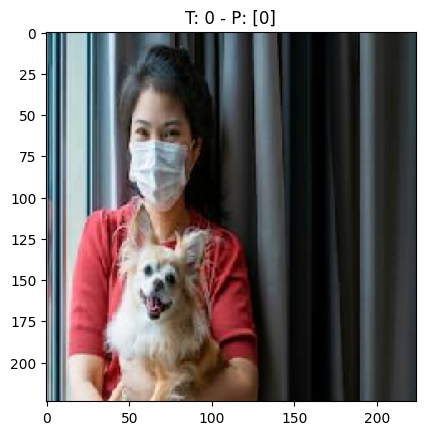

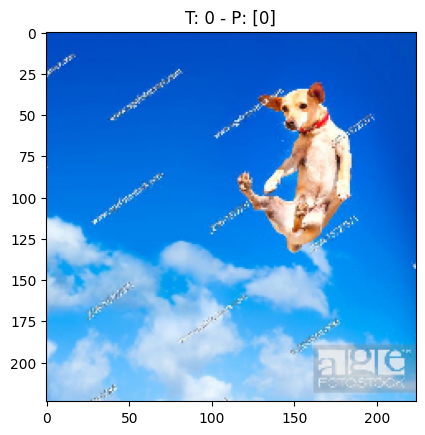

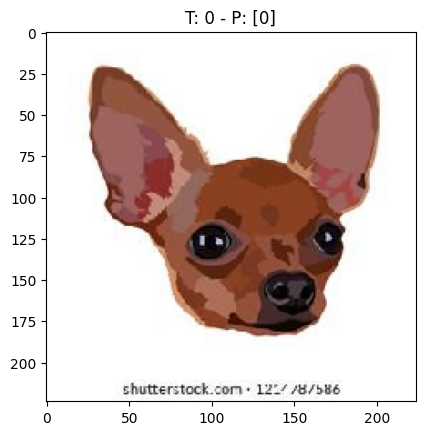

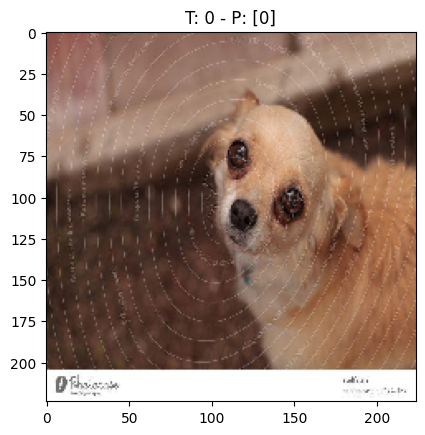

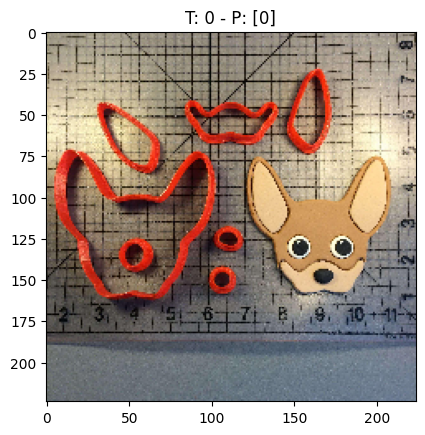

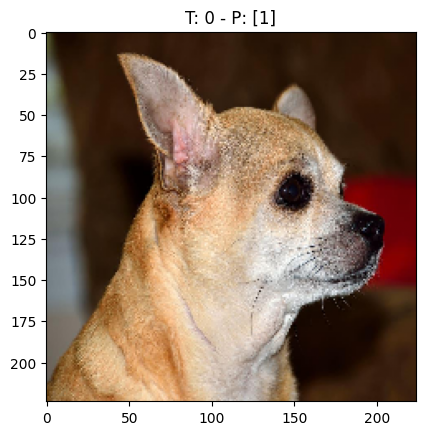

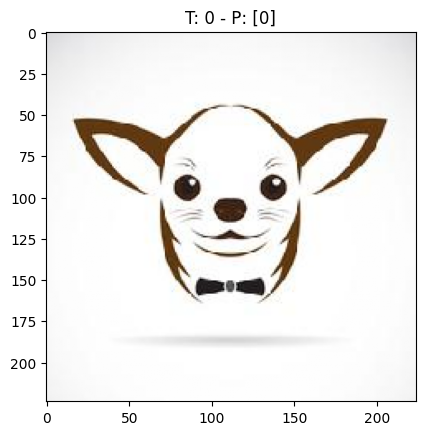

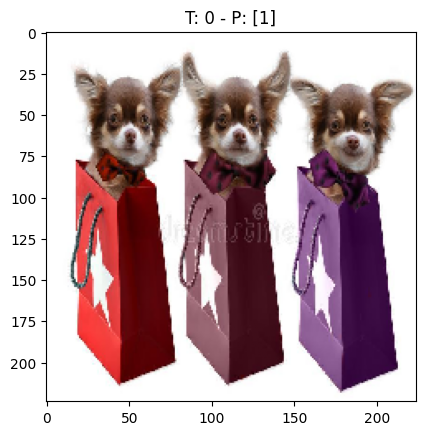

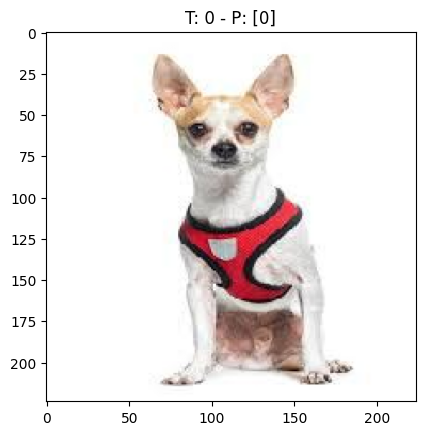

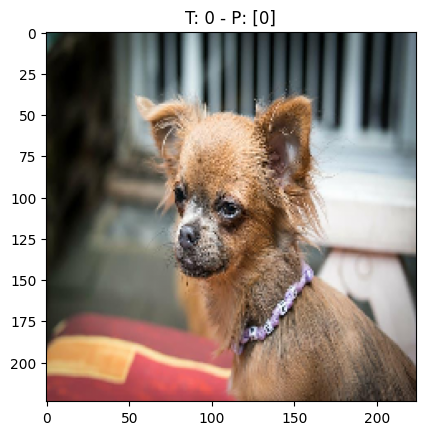

In [ ]:
for i in range(10):
    image = test_dataset[i]
    plt.imshow(image)
    plt.title(f"T: {test_labels[i]} - P: {predicted_classes[i]}")
    plt.show()

### plot confusion matrix and ROC curve

This plot is helpful to show how reliable is the results and if there is any room for improvement. Confusion matrix shows true positives, true negatives, false positives, and false negatives, which is a good criteria to evaluate the efficiency of the model. ROc shows the binary classification performance showing the true positive rate against the false positive rate over various thresholds. Maximizing the surface under ROC curve is beneficial.

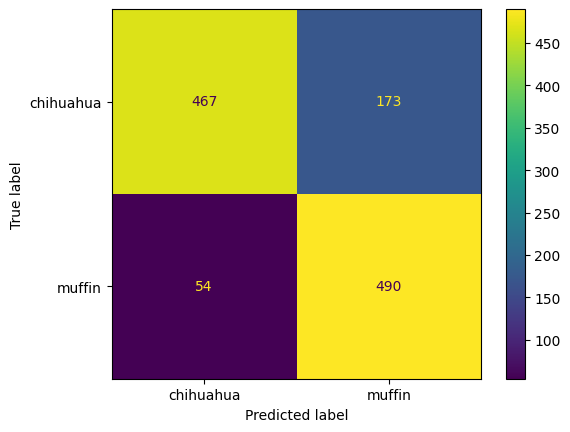

In [ ]:
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(test_labels, predicted_classes), display_labels=test_class_names).plot()

ROC: 0.8152113970588236


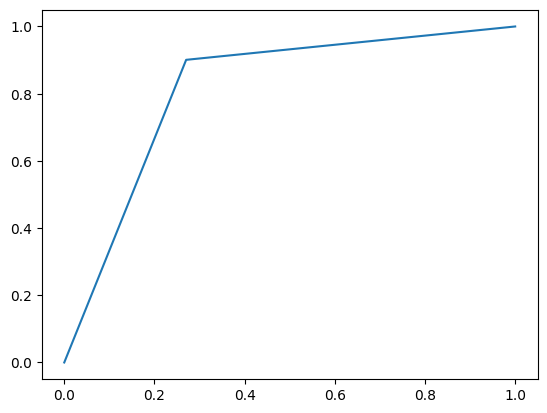

In [ ]:
fpr, tpr, thresholds = roc_curve(test_labels, predicted_classes)
plt.plot(fpr, tpr)
print('ROC:', auc(fpr, tpr))

### Calcualte best tresthold

In [ ]:
Best_threshold_idx = np.argmax(tpr - fpr)
Best_threshold = thresholds[Best_threshold_idx]

### Plot confusion matrix

37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step


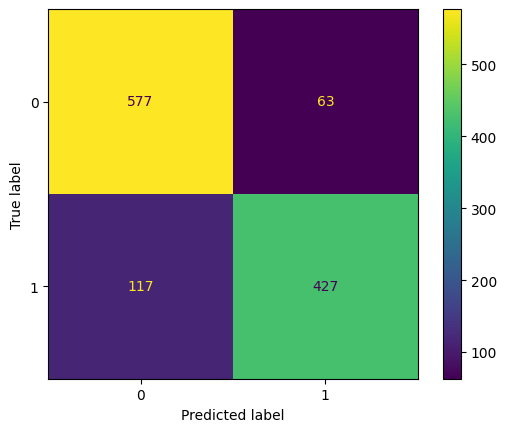

In [ ]:
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(test_labels, (cnn_model.predict(test_dataset) >= best_threshold).astype(int))).plot()

By optimizing the threshold, the total number of correctly predixted labels increase from 957 to 1004 and wrongly predicted decrease from 227 to 180.